In [116]:

import kagglehub
from kagglehub import KaggleDatasetAdapter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


# Set the path to the file you'd like to load
file_path = "BTC.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "svaningelgem/crypto-currencies-daily-prices",
  file_path,
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records: \n", df.head())

/var/folders/r0/jybzwz115yn9df3wqql357_40000gn/T/ipykernel_14341/3783707495.py:13: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


First 5 records: 
   ticker        date     open     high      low    close
0    BTC  2010-07-17  0.04951  0.04951  0.04951  0.04951
1    BTC  2010-07-18  0.04951  0.08585  0.04951  0.08584
2    BTC  2010-07-19  0.08584  0.09307  0.07723  0.08080
3    BTC  2010-07-20  0.08080  0.08181  0.07426  0.07474
4    BTC  2010-07-21  0.07474  0.07921  0.06634  0.07921


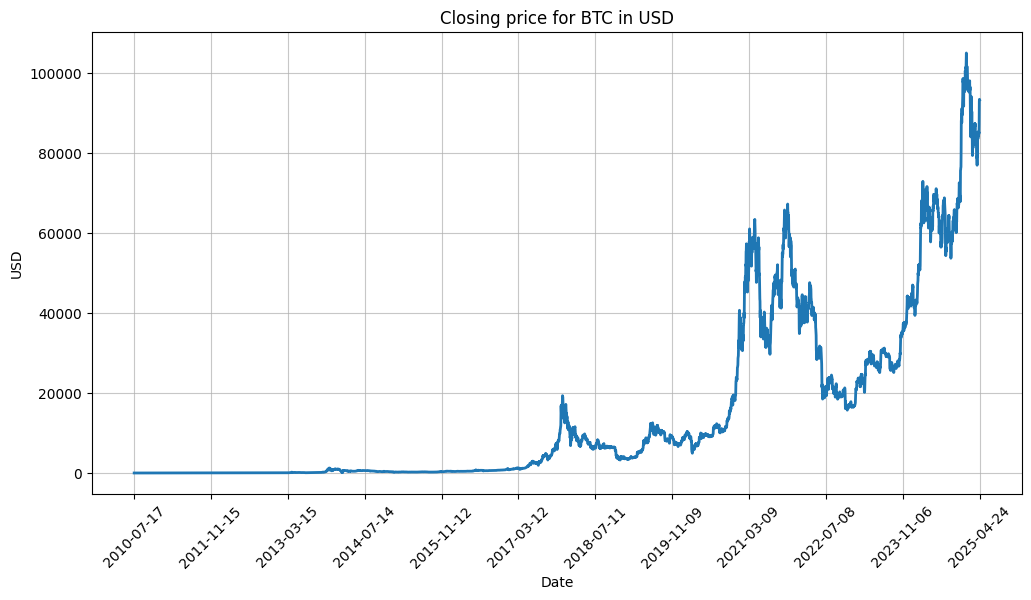

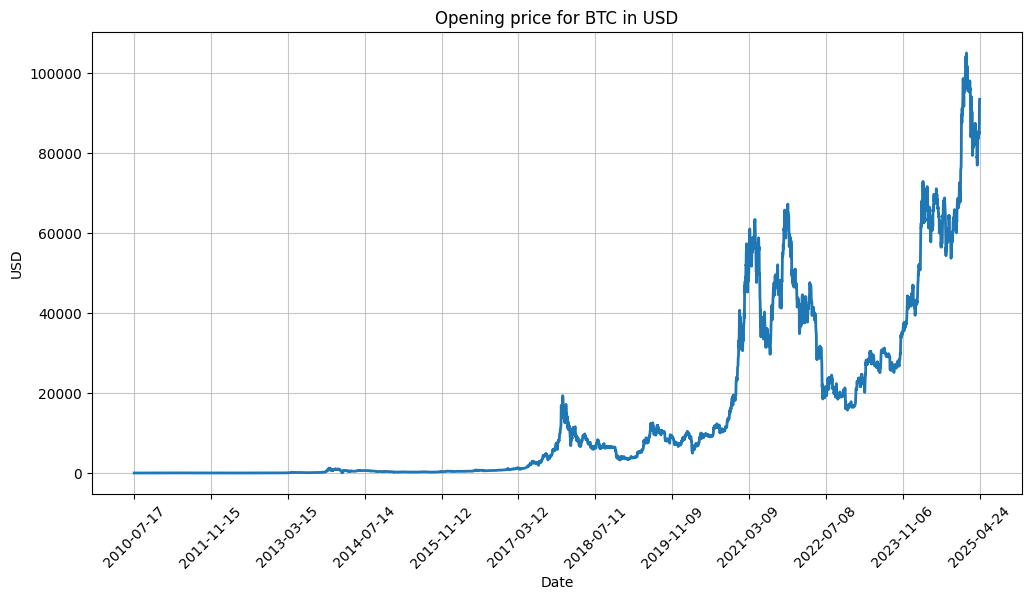

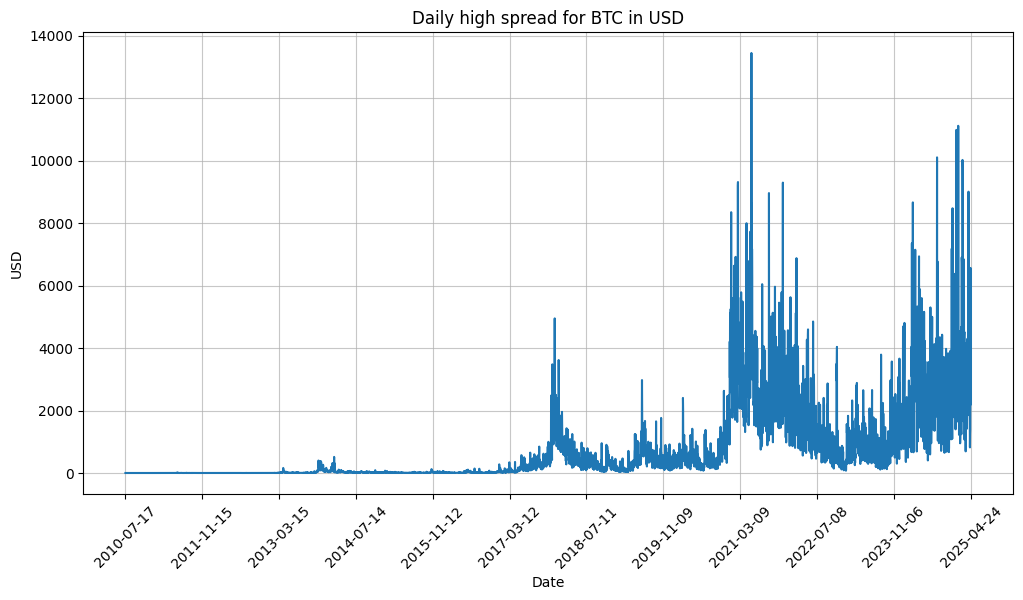

In [117]:
num_of_ticks = 12 
tick_spacing = np.linspace(0,len(df['date'])-1, num=num_of_ticks).astype(int)
plt.figure(figsize=(12,6))
plt.tight_layout()
plt.plot(df['date'], df['close'], linewidth=2)
plt.grid(alpha=.7)
plt.xlabel('Date')
plt.ylabel('USD')
plt.title("Closing price for BTC in USD")
plt.xticks(tick_spacing, df['date'].iloc[tick_spacing], rotation=45)

plt.figure(figsize=(12,6))
plt.plot(df['date'], df['open'], linewidth=2)
plt.grid(alpha=.7)
plt.xlabel('Date')
plt.ylabel('USD')
plt.title("Opening price for BTC in USD")
plt.xticks(tick_spacing, df['date'].iloc[tick_spacing], rotation=45)

plt.figure(figsize=(12,6))
plt.plot(df['date'], df['high']-df['low'])
plt.grid(alpha=.7)
plt.xlabel('Date')
plt.ylabel('USD')
plt.title("Daily high spread for BTC in USD")
plt.xticks(tick_spacing, df['date'].iloc[tick_spacing], rotation=45)
plt.tight_layout
plt.show()





In [118]:
closing_series = df['close']
closing_series.index= df['date']
closing_series.describe()

count      5348.000000
mean      14866.332663
std       22008.191627
min           0.049510
25%         237.650000
50%        3882.345000
75%       22325.625000
max      105104.000000
Name: close, dtype: float64

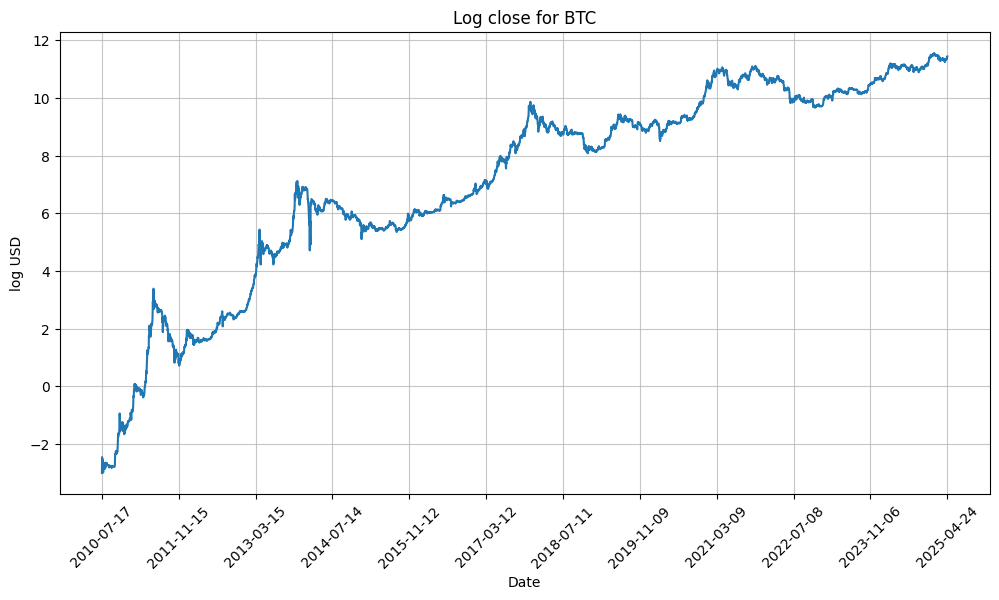

In [119]:
log_close = np.log(closing_series)
plt.figure(figsize=(12,6))
plt.plot(df['date'], log_close)
plt.grid(alpha=.7)
plt.xlabel('Date')
plt.ylabel('log USD')
plt.title("Log close for BTC")
plt.xticks(tick_spacing, df['date'].iloc[tick_spacing], rotation=45)
plt.tight_layout
plt.show()

### --------- GRU Part -----------------

In [120]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

BATCH_SIZE = 64
LOOKBACK_WINDOW = 5
NO_OF_FEATURES = 1
MAX_EPOCHS = 100

In [121]:
log_close

date
2010-07-17    -3.005581
2010-07-18    -2.455270
2010-07-19    -2.515778
2010-07-20    -2.593740
2010-07-21    -2.535653
                ...    
2025-04-20    11.350183
2025-04-21    11.376919
2025-04-22    11.440951
2025-04-23    11.445856
2025-04-24    11.444451
Name: close, Length: 5348, dtype: float64

In [122]:
def create_dataset(data, look_back = LOOKBACK_WINDOW):
    X,y = [], []
    dates = []
    for i in range(len(data)-look_back-1):
       a = data[i:(i+look_back)]
       X.append(a)
       y.append(data[i + look_back])
       dates.append(data.index[i+look_back])

    X=np.array(X)
    y=np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], NO_OF_FEATURES)) #Reshape to (BATCHS_SIZE, LOOK_BACK, features)
    return np.array(X), np.array(y),dates

X,y, dates = create_dataset(log_close)

split = int(len(X) * 0.8)

# Split the data while maintaining temporal order
X_train = X[:split]
X_test = X[split:]
Y_train = y[:split]
Y_test = y[split:]

test_set = np.exp(Y_test)

dates=dates[split:]

/var/folders/r0/jybzwz115yn9df3wqql357_40000gn/T/ipykernel_14341/1408707919.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i + look_back])


### That is now our base GRU-model. Lets see if we can make it better

In [123]:
from keras_tuner.tuners import BayesianOptimization
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    model = Sequential()
    model.add(GRU ( 
        units = hp.Int('gru_units1', 8, 128, step=8),
        activation = 'tanh',
        return_sequences=True,
        input_shape = (LOOKBACK_WINDOW, NO_OF_FEATURES)

    ))
    model.add(GRU(
        units=hp.Int('gru_units_2', 8, 128, step=16),
        activation='tanh',
        return_sequences=False
    ))
    model.add(Dense(1))


    model.compile(optimizer=Adam(
            learning_rate=hp.Choice('learning_rate', [1e-4, 1e-3, 1e-2])
        ),
        loss='mse')
    return model

tuner = BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1
)


stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5) #Add early stopping


tuner.search(X_train, Y_train, epochs=MAX_EPOCHS, validation_split=0.2, callbacks= [stop_early])

Reloading Tuner from ./untitled_project/tuner0.json


In [124]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('gru_units1')}, and for the second {best_hps.get('gru_units_2')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")



The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 128, and for the second 120 and the optimal learning rate for the optimizer
is 0.001.



# Build a model using these parameters

In [125]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, Y_train, epochs=MAX_EPOCHS, batch_size=BATCH_SIZE,validation_split=0.2, callbacks = [stop_early])
val_acc_per_epoch = history.history['val_loss']
best_epoch = val_acc_per_epoch.index(min(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/100


/Users/kevinmiramadi/BTC_project/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 9.0755 - val_loss: 3.3847
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2072 - val_loss: 0.7952
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0530 - val_loss: 0.3912
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0302 - val_loss: 0.2916
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0162 - val_loss: 0.1580
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0093 - val_loss: 0.0826
Epoch 7/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0088 - val_loss: 0.0800
Epoch 8/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0089 - val_loss: 0.0557
Epoch 9/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0063 - val_loss: 0.0583
Epoch 10/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0061 - val_loss: 0.0587
Epoch 11/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0055 - val_loss: 0.0502
Epoch 12/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0061

In [126]:
preds = model.predict(X_test)
preds =np.exp(preds)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


MAPE: 0.25292227201382445
RMSE: 17962.605971585486


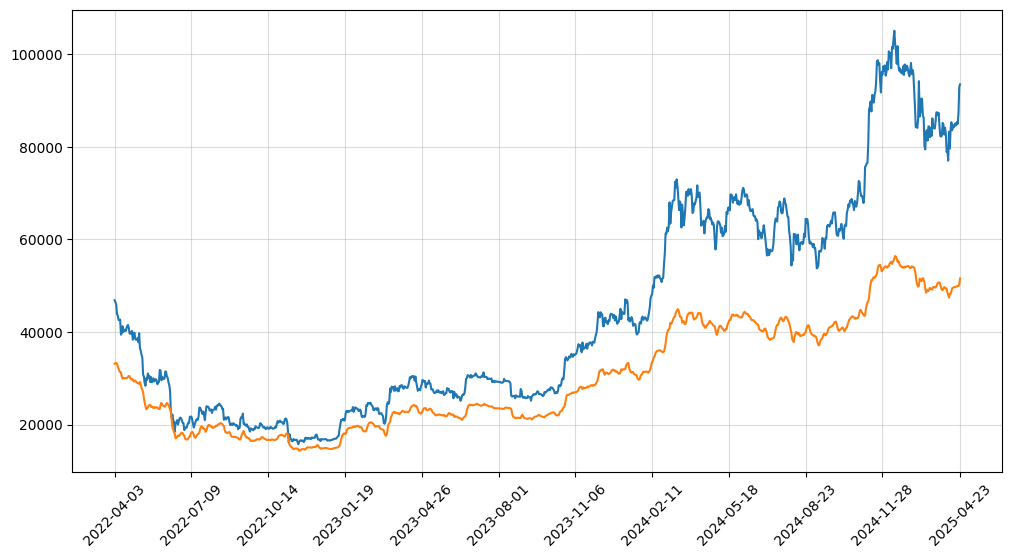

In [143]:
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error
print(f"MAPE: {mean_absolute_percentage_error(test_set, preds)}")
print(f"RMSE: {root_mean_squared_error(test_set, preds)}")

tick_spacing = np.linspace(start=0, stop = len(dates)-1, num=num_of_ticks).astype(int)

plt.figure(figsize=(12,6))
plt.plot(dates, test_set, label="True closing price")
plt.plot(dates, preds, label="Predicted")
plt.grid(alpha =  .45)
plt.xticks(tick_spacing, np.array(dates)[tick_spacing], rotation=45)
plt.show()